# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [ ]:
!pip install kaggle
!pip install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [1]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [3]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [4]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
download_path = "chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset already exists at chest_xray_dataset. Skipping download.


In [5]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Re-split dataset already exists at chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [6]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

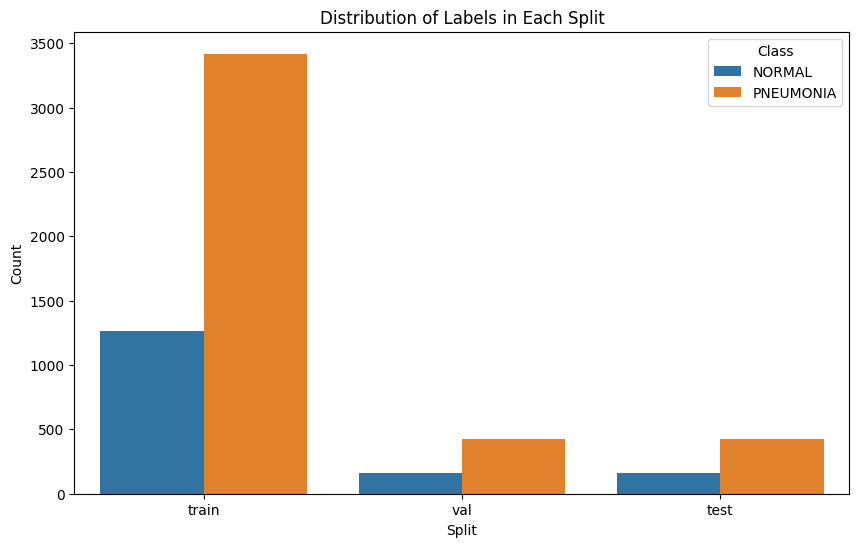

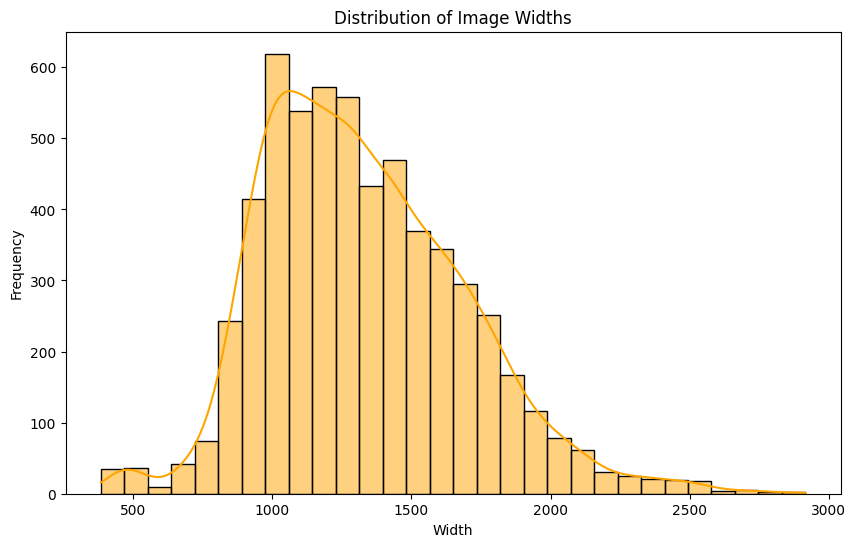

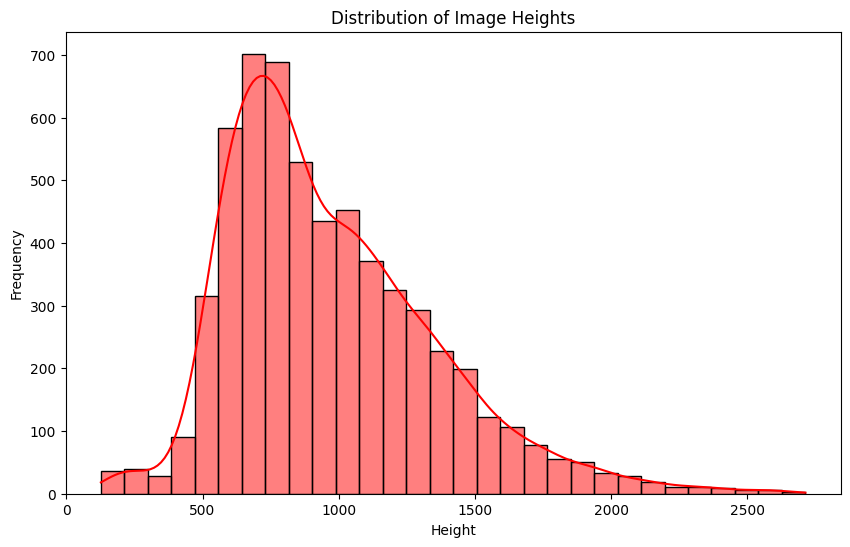

In [7]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

# Convert stats to a DataFrame for easier visualization
stats_df = pd.DataFrame(stats).reset_index().melt(id_vars='index')
stats_df.columns = ['Class', 'Split', 'Count']

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Split', y='Count', hue='Class', data=stats_df)
plt.title('Distribution of Labels in Each Split')
plt.show()

# Analyze input features (btw in this case is image dimensions)
image_dimensions = {'width': [], 'height': []}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        for file in os.listdir(path):
            img = Image.open(os.path.join(path, file))
            width, height = img.size
            image_dimensions['width'].append(width)
            image_dimensions['height'].append(height)

# Convert image dimensions to a DataFrame BETTER VISUALIZATION
dimensions_df = pd.DataFrame(image_dimensions)

# Plot the distribution of image widths
plt.figure(figsize=(10, 6))
sns.histplot(dimensions_df['width'], kde=True, bins=30, color='orange')
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of image heights
plt.figure(figsize=(10, 6))
sns.histplot(dimensions_df['height'], kde=True, bins=30, color='red')
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()


**(a)**
The distribution of the classes ("NORMAL" and "PNEUMONIA") across the training, validation, and test sets. The class distribution seems highly imbalanced in all splits such that the "PNEUMONIA" class has significantly more images than the "NORMAL" class in all three datasets (train, validation, and test). While training, this will make the classifier biased towards predicting "PNEUMONIA" more frequently since it appears much more often in the dataset. And this could lead to poor performance when predicting the minority class ("NORMAL") if nothing is done to solve this problem.

The distribution of image widths and heights shows that the images seem to vary in size, but the majority of the images have a width between 500-1500 pixels and a height between 500-2000 pixels. It would do am impact on training, since our model often requires fixed-size inputs. We would need to resize them to a uniform size before feeding them into our model, which, if you don't do that, would result in poor convergence, lower accuracy, and suboptimal performance for training. While resizing sometimes causes distortions which could affect the model's ability to learn useful pattern.

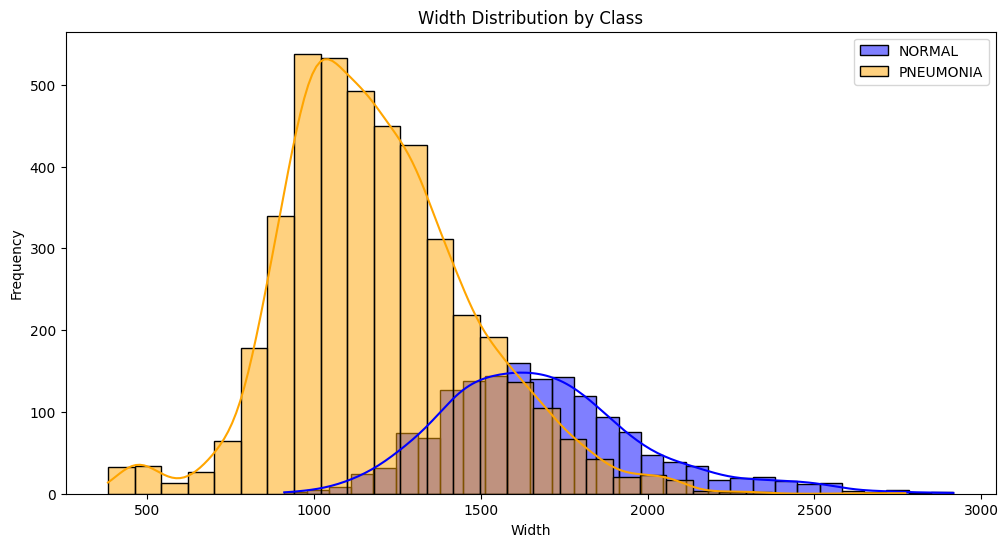

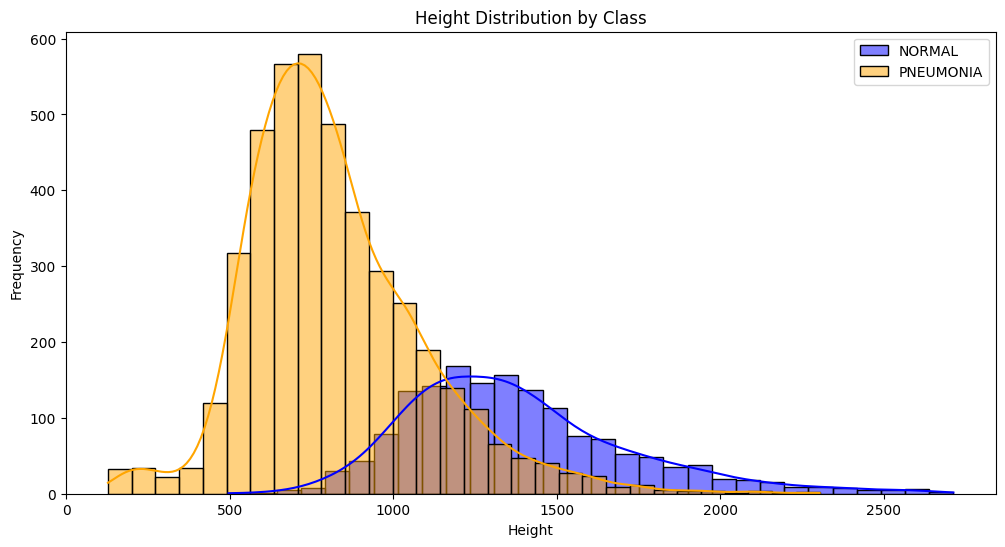

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

# Initialize dictionaries to hold dimensions for each class
image_dimensions_classwise = {'NORMAL': {'width': [], 'height': []},
                              'PNEUMONIA': {'width': [], 'height': []}}

# Gather dimensions class-wise
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        for file in os.listdir(path):
            img = Image.open(os.path.join(path, file))
            width, height = img.size
            image_dimensions_classwise[cls]['width'].append(width)
            image_dimensions_classwise[cls]['height'].append(height)

# Convert to DataFrame for easier visualization
normal_dimensions_df = pd.DataFrame(image_dimensions_classwise['NORMAL'])
pneumonia_dimensions_df = pd.DataFrame(image_dimensions_classwise['PNEUMONIA'])

# Plot width distribution for NORMAL and PNEUMONIA
plt.figure(figsize=(12, 6))
sns.histplot(normal_dimensions_df['width'], kde=True, bins=30, color='blue', label='NORMAL')
sns.histplot(pneumonia_dimensions_df['width'], kde=True, bins=30, color='orange', label='PNEUMONIA')
plt.title('Width Distribution by Class')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot height distribution for NORMAL and PNEUMONIA
plt.figure(figsize=(12, 6))
sns.histplot(normal_dimensions_df['height'], kde=True, bins=30, color='blue', label='NORMAL')
sns.histplot(pneumonia_dimensions_df['height'], kde=True, bins=30, color='orange', label='PNEUMONIA')
plt.title('Height Distribution by Class')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()
plt.show()


(a) The distribution plots for width and height across "NORMAL" and "PNEUMONIA" images show significant differences in the size distributions of the two classes. If nothing is done, it would make the model to be likely to classify a general small image as PNEUMONIA. In other words, the model might learn to associate small image dimensions with the "PNEUMONIA" label, rather than focusing on actual disease-related features.

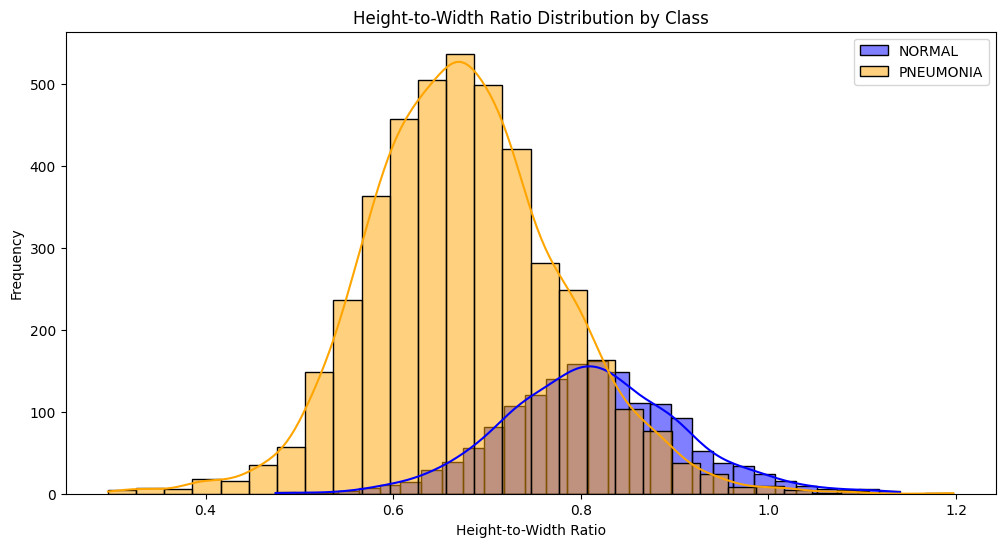

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate height-to-width ratios for each class
image_ratios_classwise = {'NORMAL': [], 'PNEUMONIA': []}

# Iterate through each class and calculate height-to-width ratios
for cls in classes:
    widths = image_dimensions_classwise[cls]['width']
    heights = image_dimensions_classwise[cls]['height']
    ratios = [h / w for h, w in zip(heights, widths)]
    image_ratios_classwise[cls] = ratios

# Convert ratios to DataFrames for easier visualization
normal_ratios_df = pd.DataFrame(image_ratios_classwise['NORMAL'], columns=['Height-to-Width Ratio'])
pneumonia_ratios_df = pd.DataFrame(image_ratios_classwise['PNEUMONIA'], columns=['Height-to-Width Ratio'])

# Plot height-to-width ratio distribution for NORMAL and PNEUMONIA
plt.figure(figsize=(12, 6))
sns.histplot(normal_ratios_df['Height-to-Width Ratio'], kde=True, bins=30, color='blue', label='NORMAL')
sns.histplot(pneumonia_ratios_df['Height-to-Width Ratio'], kde=True, bins=30, color='orange', label='PNEUMONIA')
plt.title('Height-to-Width Ratio Distribution by Class')
plt.xlabel('Height-to-Width Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()


(a) Aspect ratio may be unintentionally learned by the model as a characteristic linked to every class. Regardless of the true disease characteristics, this could result in bias where the input images with lower height-to-width ratios are more likely to be labeled as "PNEUMONIA" and vice versa.

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [10]:
dataset_path = "chest_xray_dataset_new_split"
batch_size = 32

In [62]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.images = []
        self.labels = []
        self.load_dataset()

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.images)
    
    
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    def __getitem__(self, idx):

        img_path = self.images[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('L')

        if self.transform:
            img = self.transform(img)

        return img, label

    
    def load_dataset(self):
        normal_path = os.path.join(self.root_dir, self.split, 'NORMAL')
        pneumonia_path = os.path.join(self.root_dir, self.split, 'PNEUMONIA')

        normal_files = [os.path.join(normal_path, file) for file in os.listdir(normal_path)]
        pneumonia_files = [os.path.join(pneumonia_path, file) for file in os.listdir(pneumonia_path)]

        self.images = normal_files + pneumonia_files
        self.labels = [0] * len(normal_files) + [1] * len(pneumonia_files)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [63]:
from torchvision import transforms

# Define transformations
########################################################################
#                              YOUR CODE HERE                          #
########################################################################


transform = transforms.Compose([
    transforms.Resize(256),  # Resize shorter side to 256 while keeping aspect ratio
    transforms.CenterCrop((256, 256)),  # Pad to make the image 256x256 without distortion
    # transforms.RandomHorizontalFlip(),  # Random horizontal flip (Does it make sense?)
    transforms.RandomRotation(degrees=5),  # Random rotation 5 degree
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Brightness and contrast adjustments
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images to [-1, 1]
])


########################################################################
#                             END OF YOUR CODE                         #
########################################################################

To git rid of the imbalanced dataset effect, we do a weightedRandomSampler using the inverse of the frequency of each class

In [64]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
# Create datasets
train_dataset = ChestXrayDataset(root_dir=dataset_path, split='train', transform=transform)
val_dataset = ChestXrayDataset(root_dir=dataset_path, split='val', transform=transform)
test_dataset = ChestXrayDataset(root_dir=dataset_path, split='test', transform=transform)

# Create data loaders
# Count the number of samples in each class
normal_count = len([label for label in train_dataset.labels if label == 0])
pneumonia_count = len([label for label in train_dataset.labels if label == 1])

# Define the weights for each class
class_weights = [1.0 / normal_count, 1.0 / pneumonia_count]
sample_weights = [class_weights[label] for label in train_dataset.labels]

# Create the WeightedRandomSampler to fix the imbalanced data
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

# Create data loaders with the sampler for the training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Print batch shapes
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Train dataset size: 4684
Validation dataset size: 585
Test dataset size: 587
Batch images shape: torch.Size([32, 1, 256, 256])
Batch labels shape: torch.Size([32])


In [50]:
# Code to check class balance in the balanced train_loader
from collections import Counter

class_counts = Counter()

# Iterate through the train_loader to count each class in sampled batches
for _, labels in train_loader:
    class_counts.update(labels.tolist())

# Display the count for each class
print("Class counts in the balanced train_loader:", class_counts)


Class counts in the balanced train_loader: Counter({1: 2369, 0: 2315})


It is now balanced! Both classes are relatively equally represented during training! GOOOD

**(a)**

_Insert brief discussion of any design choices you made here_

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [65]:
num_epochs = 30
use_wandb = True  # Set to True if you want to use wandb
lr = 0.0001

In [66]:
from torchsummary import summary 

class SimpleModel(nn.Module):
    def __init__(self, input_size=256, num_classes=2):
        super().__init__()
        
        # Two convolutional layers followed by ReLU and average pooling
        self.conv_relu_pool = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Layer 1
            nn.ReLU(),
            nn.AvgPool2d(2),  # Reduces size to 128x128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Layer 2
            nn.ReLU(),
            nn.AvgPool2d(2)  # Reduces size to 64x64
        )

        # Calculate the final size after two pooling layers
        final_size = input_size // 4  # After two AvgPool2d(2) layers, the size is divided by 4
        self.flatten = nn.Flatten()

        # Fully connected layer for classification
        self.out_layer = nn.Linear(final_size * final_size * 32, num_classes)

    def forward(self, x):
        x = self.conv_relu_pool(x)
        x = self.flatten(x)
        x = self.out_layer(x)
        return x

# Define the input size and number of classes
input_size = 256
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the device
model = SimpleModel(input_size=input_size, num_classes=num_classes).to(device)

# Print a summary of the model to check the dimensions
summary(model, (1, 256, 256))

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         AvgPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         AvgPool2d-6           [-1, 32, 64, 64]               0
           Flatten-7               [-1, 131072]               0
            Linear-8                    [-1, 2]         262,146
Total params: 266,946
Trainable params: 266,946
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 28.00
Params size (MB): 1.02
Estimated Total Size (MB): 29.27
----------------------------------------------------------------


In [67]:
def calculate_class_accuracy(outputs, labels):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

    # Get the predicted classes by taking the index of the max log-probability
    _, predicted = torch.max(outputs, 1)
    # Compare predicted classes with true labels
    correct = (predicted == labels).sum().item()
    # Calculate accuracy
    accuracy = correct / labels.size(0) * 100
    return accuracy

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


The intermediate functions to do the function: train_model

In [68]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
def train_epoch(model, train_loader, criterion, optimizer, device):
    """ Train the model for one epoch and return loss and accuracy """
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for batch_images, batch_labels in train_loader:
        # Move data to the device (CPU/GPU)
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        batch_accuracy = calculate_class_accuracy(outputs, batch_labels)
        running_accuracy += batch_accuracy

    # Average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    return epoch_loss, epoch_accuracy


In [69]:
def validate_epoch(model, val_loader, criterion, device):
    """ Validate the model and return loss and accuracy """
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            # Move data to the device (CPU/GPU)
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            # Forward pass
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)

            # Update running loss and accuracy
            running_loss += loss.item()
            batch_accuracy = calculate_class_accuracy(outputs, batch_labels)
            running_accuracy += batch_accuracy

    # Average loss and accuracy
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = running_accuracy / len(val_loader)
    return epoch_loss, epoch_accuracy
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

In [70]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False):  
    # Initialize lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    train_class_accuracies = []
    val_class_accuracies = []

    # Initialize wandb if required
    if use_wandb:
        import wandb
        wandb.init(project="chest_xray_classification")
        wandb.watch(model, log="all")

    # Progress bar for epochs
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Train for one epoch
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validate after each epoch
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Log the results (wandb or print)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        if use_wandb:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            })

    print("Training complete.")
    if use_wandb:
        wandb.finish()

    # Return all tracked metrics
    return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies

########################################################################
#                             END OF YOUR CODE                         #
########################################################################

## Now we do plotting functions!

In [71]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot training and validation losses
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Loss vs. Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training and validation accuracies
    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title('Accuracy vs. Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Optional: plot class accuracies in separate figures
    if train_class_accuracies and val_class_accuracies:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot training class accuracies
        axs[0].plot(train_class_accuracies, label='Training Class Accuracy')
        axs[0].set_title('Training Class Accuracy vs. Epochs')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Accuracy (%)')
        axs[0].legend()

        # Plot validation class accuracies
        axs[1].plot(val_class_accuracies, label='Validation Class Accuracy')
        axs[1].set_title('Validation Class Accuracy vs. Epochs')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy (%)')
        axs[1].legend()

        plt.tight_layout()
        plt.show()
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


epoch,▁▃▅▆█
train_accuracy,▄█▄▂▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁██
val_loss,▆█▅▁▃
epoch,5
train_accuracy,49.34099
train_loss,0.69382
val_accuracy,74.01316
val_loss,0.68336


Training Progress:   3%|▎         | 1/30 [00:46<22:17, 46.11s/it]

Epoch [1/30], Train Loss: 0.2944, Train Accuracy: 88.01%
Validation Loss: 0.2335, Validation Accuracy: 91.03%


Training Progress:   7%|▋         | 2/30 [01:38<23:06, 49.53s/it]

Epoch [2/30], Train Loss: 0.2313, Train Accuracy: 90.89%
Validation Loss: 0.2597, Validation Accuracy: 89.71%


Training Progress:  10%|█         | 3/30 [02:35<23:57, 53.24s/it]

Epoch [3/30], Train Loss: 0.2023, Train Accuracy: 92.11%
Validation Loss: 0.1536, Validation Accuracy: 94.74%


Training Progress:  13%|█▎        | 4/30 [03:23<22:11, 51.22s/it]

Epoch [4/30], Train Loss: 0.1818, Train Accuracy: 93.20%
Validation Loss: 0.1645, Validation Accuracy: 93.49%


Training Progress:  17%|█▋        | 5/30 [04:14<21:13, 50.96s/it]

Epoch [5/30], Train Loss: 0.1837, Train Accuracy: 93.03%
Validation Loss: 0.1723, Validation Accuracy: 93.00%


Training Progress:  20%|██        | 6/30 [05:10<21:04, 52.69s/it]

Epoch [6/30], Train Loss: 0.1611, Train Accuracy: 93.59%
Validation Loss: 0.1940, Validation Accuracy: 92.84%


Training Progress:  23%|██▎       | 7/30 [06:07<20:48, 54.27s/it]

Epoch [7/30], Train Loss: 0.1635, Train Accuracy: 93.93%
Validation Loss: 0.1453, Validation Accuracy: 95.23%


Training Progress:  27%|██▋       | 8/30 [07:06<20:27, 55.79s/it]

Epoch [8/30], Train Loss: 0.1616, Train Accuracy: 93.97%
Validation Loss: 0.1540, Validation Accuracy: 93.82%


Training Progress:  30%|███       | 9/30 [08:05<19:49, 56.62s/it]

Epoch [9/30], Train Loss: 0.1514, Train Accuracy: 94.32%
Validation Loss: 0.1328, Validation Accuracy: 96.71%


Training Progress:  33%|███▎      | 10/30 [09:04<19:07, 57.36s/it]

Epoch [10/30], Train Loss: 0.1509, Train Accuracy: 94.56%
Validation Loss: 0.1582, Validation Accuracy: 94.15%


Training Progress:  37%|███▋      | 11/30 [10:01<18:07, 57.22s/it]

Epoch [11/30], Train Loss: 0.1393, Train Accuracy: 94.66%
Validation Loss: 0.1270, Validation Accuracy: 95.56%


Training Progress:  40%|████      | 12/30 [10:49<16:21, 54.50s/it]

Epoch [12/30], Train Loss: 0.1503, Train Accuracy: 94.64%
Validation Loss: 0.1375, Validation Accuracy: 94.57%


Training Progress:  43%|████▎     | 13/30 [11:47<15:43, 55.52s/it]

Epoch [13/30], Train Loss: 0.1356, Train Accuracy: 94.75%
Validation Loss: 0.1586, Validation Accuracy: 93.82%


Training Progress:  47%|████▋     | 14/30 [12:45<15:01, 56.35s/it]

Epoch [14/30], Train Loss: 0.1404, Train Accuracy: 94.82%
Validation Loss: 0.1821, Validation Accuracy: 92.67%


Training Progress:  50%|█████     | 15/30 [13:42<14:07, 56.52s/it]

Epoch [15/30], Train Loss: 0.1325, Train Accuracy: 95.30%
Validation Loss: 0.1376, Validation Accuracy: 94.90%


Training Progress:  53%|█████▎    | 16/30 [14:38<13:10, 56.43s/it]

Epoch [16/30], Train Loss: 0.1404, Train Accuracy: 94.78%
Validation Loss: 0.1422, Validation Accuracy: 95.56%


Training Progress:  57%|█████▋    | 17/30 [15:33<12:07, 55.93s/it]

Epoch [17/30], Train Loss: 0.1315, Train Accuracy: 94.95%
Validation Loss: 0.1372, Validation Accuracy: 95.63%


Training Progress:  60%|██████    | 18/30 [16:23<10:48, 54.00s/it]

Epoch [18/30], Train Loss: 0.1338, Train Accuracy: 95.20%
Validation Loss: 0.1319, Validation Accuracy: 94.90%


Training Progress:  63%|██████▎   | 19/30 [17:15<09:47, 53.37s/it]

Epoch [19/30], Train Loss: 0.1197, Train Accuracy: 95.27%
Validation Loss: 0.1497, Validation Accuracy: 94.74%


Training Progress:  67%|██████▋   | 20/30 [18:03<08:38, 51.90s/it]

Epoch [20/30], Train Loss: 0.1169, Train Accuracy: 95.46%
Validation Loss: 0.1546, Validation Accuracy: 94.65%


Training Progress:  70%|███████   | 21/30 [18:50<07:34, 50.53s/it]

Epoch [21/30], Train Loss: 0.1217, Train Accuracy: 95.30%
Validation Loss: 0.1475, Validation Accuracy: 95.39%


Training Progress:  73%|███████▎  | 22/30 [19:37<06:35, 49.42s/it]

Epoch [22/30], Train Loss: 0.1043, Train Accuracy: 96.37%
Validation Loss: 0.1590, Validation Accuracy: 94.48%


Training Progress:  77%|███████▋  | 23/30 [20:21<05:34, 47.82s/it]

Epoch [23/30], Train Loss: 0.1261, Train Accuracy: 95.00%
Validation Loss: 0.1700, Validation Accuracy: 93.82%


Training Progress:  80%|████████  | 24/30 [21:18<05:02, 50.40s/it]

Epoch [24/30], Train Loss: 0.1149, Train Accuracy: 95.88%
Validation Loss: 0.1601, Validation Accuracy: 94.32%


Training Progress:  83%|████████▎ | 25/30 [22:15<04:22, 52.45s/it]

Epoch [25/30], Train Loss: 0.0971, Train Accuracy: 96.63%
Validation Loss: 0.1739, Validation Accuracy: 93.49%


Training Progress:  87%|████████▋ | 26/30 [23:13<03:36, 54.05s/it]

Epoch [26/30], Train Loss: 0.1130, Train Accuracy: 96.09%
Validation Loss: 0.1759, Validation Accuracy: 93.17%


Training Progress:  90%|█████████ | 27/30 [24:12<02:46, 55.55s/it]

Epoch [27/30], Train Loss: 0.1017, Train Accuracy: 96.60%
Validation Loss: 0.1868, Validation Accuracy: 93.00%


Training Progress:  93%|█████████▎| 28/30 [25:10<01:52, 56.37s/it]

Epoch [28/30], Train Loss: 0.1121, Train Accuracy: 95.81%
Validation Loss: 0.1748, Validation Accuracy: 94.57%


Training Progress:  97%|█████████▋| 29/30 [26:08<00:56, 56.96s/it]

Epoch [29/30], Train Loss: 0.0999, Train Accuracy: 96.56%
Validation Loss: 0.1927, Validation Accuracy: 92.67%


Training Progress: 100%|██████████| 30/30 [27:08<00:00, 54.27s/it]

Epoch [30/30], Train Loss: 0.0940, Train Accuracy: 96.46%
Validation Loss: 0.1606, Validation Accuracy: 94.32%
Training complete.


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▃▄▅▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇█▇▇███▇██
train_loss,█▆▅▄▄▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▁▂▂▁▂▁▂▁▁
val_accuracy,▂▁▆▅▄▄▇▅█▅▇▆▅▄▆▇▇▆▆▆▇▆▅▆▅▄▄▆▄▆
val_loss,▇█▂▃▃▅▂▂▁▃▁▂▃▄▂▂▂▁▂▂▂▃▃▃▃▄▄▄▄▃
epoch,30
train_accuracy,96.45692
train_loss,0.09395
val_accuracy,94.31652
val_loss,0.16057


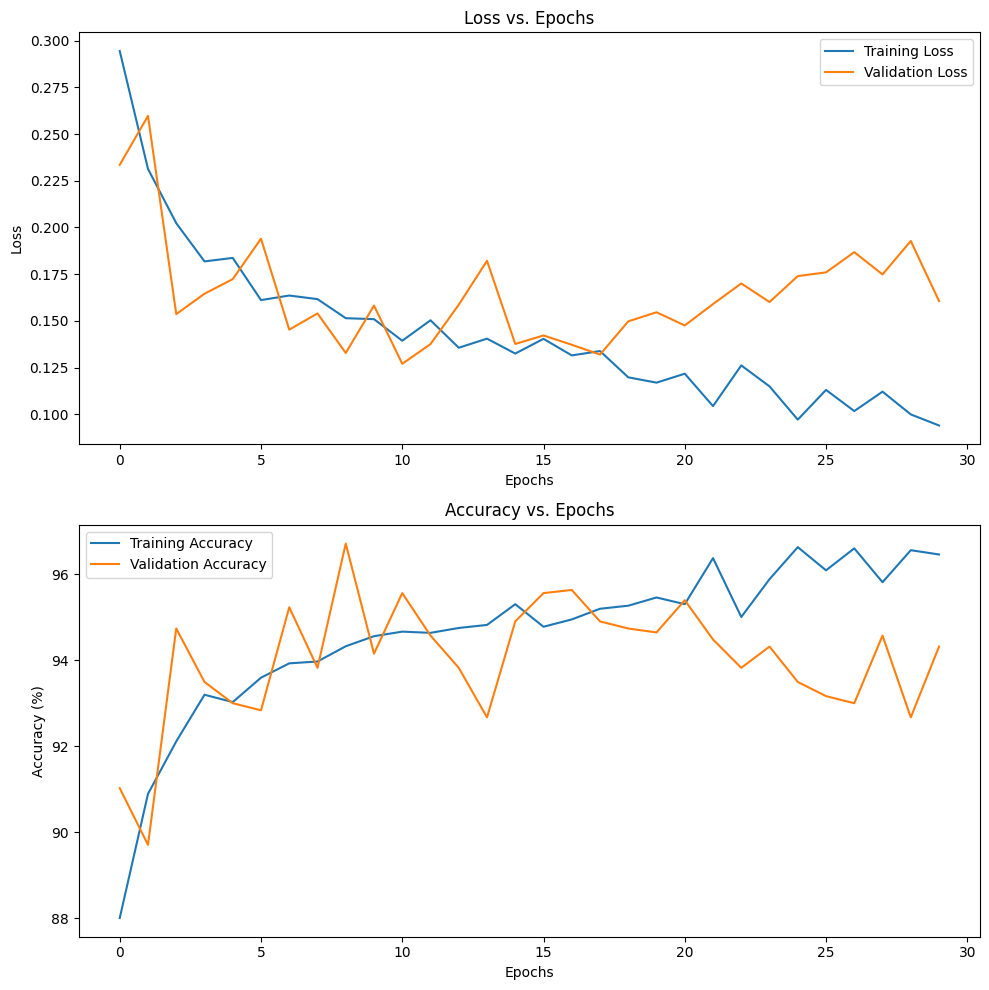

Model saved as 'chest_xray_model.pth'


In [72]:
# Initialize the model
model = SimpleModel().to(device)

# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

# Loss function for binary classification (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
learning_rate = 0.0001 # Define again in case I forgot
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'chest_xray_model.pth')
print("Model saved as 'chest_xray_model.pth'")

**(a)**

_Insert brief explanation of the design choices you made_

**(b)**

_Present your results, including plots etc. here_

**(c)**

_Discuss your results here_

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [ ]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

*Insert a brief explanation of the three improvements you have used*

*For each improvment:*
1. *State the change being made;*
2. *State **why** this change could, in theory, improve the performance of the baseline model. If possible, motivate your hypothesis using empirical evidence from the baseline models results*

**(b)**

_Present your results, including plots etc, here_

(Hint: ensure you compare to the baseline)

**(c)**

_Discuss your results here_

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


**I choose Option 2: Compare with the Baseline.**

In [73]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

class ImproveGeneralizationModel(nn.Module):
    def __init__(self, input_size=256, num_classes=2):
        super().__init__()
        
        # Two convolutional layers followed by ReLU and average pooling
        self.conv_relu_pool = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Layer 1
            nn.ReLU(),
            nn.AvgPool2d(2),  # Reduces size to 128x128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Layer 2
            nn.ReLU(),
            nn.AvgPool2d(2)  # Reduces size to 64x64
        )

        # Calculate the final size after two pooling layers
        final_size = input_size // 4  # After two AvgPool2d(2) layers, the size is divided by 4
        self.flatten = nn.Flatten()

        # Fully connected layer with dropout
        self.fc = nn.Sequential(
            nn.Linear(final_size * final_size * 32, 64),  # Reduced to 64 neurons
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer to reduce overfitting
            nn.Linear(64, num_classes)  # Final output layer for binary classification
        )

    def forward(self, x):
        x = self.conv_relu_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Define the input size and number of classes
input_size = 256
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the device
model = ImproveGeneralizationModel(input_size=input_size, num_classes=num_classes).to(device)

# Print a summary of the model to check the dimensions
summary(model, (1, 256, 256))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
              ReLU-2         [-1, 16, 256, 256]               0
         AvgPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
              ReLU-5         [-1, 32, 128, 128]               0
         AvgPool2d-6           [-1, 32, 64, 64]               0
           Flatten-7               [-1, 131072]               0
            Linear-8                   [-1, 64]       8,388,672
              ReLU-9                   [-1, 64]               0
          Dropout-10                   [-1, 64]               0
           Linear-11                    [-1, 2]             130
Total params: 8,393,602
Trainable params: 8,393,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forw

Training Progress:   3%|▎         | 1/30 [00:58<28:25, 58.83s/it]

Epoch [1/30], Train Loss: 0.3234, Train Accuracy: 85.95%
Validation Loss: 0.1614, Validation Accuracy: 93.00%


Training Progress:   7%|▋         | 2/30 [01:58<27:39, 59.26s/it]

Epoch [2/30], Train Loss: 0.2386, Train Accuracy: 91.27%
Validation Loss: 0.1766, Validation Accuracy: 93.99%


Training Progress:  10%|█         | 3/30 [02:57<26:41, 59.31s/it]

Epoch [3/30], Train Loss: 0.2147, Train Accuracy: 91.16%
Validation Loss: 0.1826, Validation Accuracy: 93.99%


Training Progress:  13%|█▎        | 4/30 [03:56<25:40, 59.24s/it]

Epoch [4/30], Train Loss: 0.1826, Train Accuracy: 93.41%
Validation Loss: 0.1566, Validation Accuracy: 94.15%


Training Progress:  17%|█▋        | 5/30 [04:56<24:42, 59.32s/it]

Epoch [5/30], Train Loss: 0.1939, Train Accuracy: 92.56%
Validation Loss: 0.1642, Validation Accuracy: 93.99%


Training Progress:  20%|██        | 6/30 [05:55<23:42, 59.29s/it]

Epoch [6/30], Train Loss: 0.1685, Train Accuracy: 93.64%
Validation Loss: 0.1934, Validation Accuracy: 92.84%


Training Progress:  23%|██▎       | 7/30 [06:55<22:46, 59.41s/it]

Epoch [7/30], Train Loss: 0.1643, Train Accuracy: 93.86%
Validation Loss: 0.1666, Validation Accuracy: 93.82%


Training Progress:  27%|██▋       | 8/30 [07:54<21:45, 59.33s/it]

Epoch [8/30], Train Loss: 0.1536, Train Accuracy: 94.41%
Validation Loss: 0.1386, Validation Accuracy: 94.81%


Training Progress:  30%|███       | 9/30 [08:54<20:48, 59.46s/it]

Epoch [9/30], Train Loss: 0.1717, Train Accuracy: 93.35%
Validation Loss: 0.1492, Validation Accuracy: 94.81%


Training Progress:  33%|███▎      | 10/30 [09:53<19:49, 59.48s/it]

Epoch [10/30], Train Loss: 0.1535, Train Accuracy: 94.11%
Validation Loss: 0.1393, Validation Accuracy: 94.57%


Training Progress:  37%|███▋      | 11/30 [10:53<18:50, 59.52s/it]

Epoch [11/30], Train Loss: 0.1614, Train Accuracy: 93.74%
Validation Loss: 0.1371, Validation Accuracy: 95.07%


Training Progress:  40%|████      | 12/30 [11:52<17:49, 59.41s/it]

Epoch [12/30], Train Loss: 0.1503, Train Accuracy: 94.28%
Validation Loss: 0.1420, Validation Accuracy: 94.97%


Training Progress:  43%|████▎     | 13/30 [12:51<16:49, 59.36s/it]

Epoch [13/30], Train Loss: 0.1362, Train Accuracy: 94.71%
Validation Loss: 0.1146, Validation Accuracy: 96.22%


Training Progress:  47%|████▋     | 14/30 [13:50<15:47, 59.20s/it]

Epoch [14/30], Train Loss: 0.1411, Train Accuracy: 94.53%
Validation Loss: 0.1780, Validation Accuracy: 93.33%


Training Progress:  50%|█████     | 15/30 [14:50<14:50, 59.34s/it]

Epoch [15/30], Train Loss: 0.1306, Train Accuracy: 95.31%
Validation Loss: 0.1275, Validation Accuracy: 95.56%


Training Progress:  53%|█████▎    | 16/30 [15:50<13:53, 59.54s/it]

Epoch [16/30], Train Loss: 0.1327, Train Accuracy: 94.58%
Validation Loss: 0.1461, Validation Accuracy: 94.48%


Training Progress:  57%|█████▋    | 17/30 [16:49<12:52, 59.39s/it]

Epoch [17/30], Train Loss: 0.1224, Train Accuracy: 95.26%
Validation Loss: 0.1221, Validation Accuracy: 96.05%


Training Progress:  60%|██████    | 18/30 [17:48<11:51, 59.26s/it]

Epoch [18/30], Train Loss: 0.1357, Train Accuracy: 95.03%
Validation Loss: 0.1495, Validation Accuracy: 93.66%


Training Progress:  63%|██████▎   | 19/30 [18:47<10:51, 59.24s/it]

Epoch [19/30], Train Loss: 0.1185, Train Accuracy: 95.49%
Validation Loss: 0.1323, Validation Accuracy: 95.39%


Training Progress:  67%|██████▋   | 20/30 [19:46<09:53, 59.34s/it]

Epoch [20/30], Train Loss: 0.1233, Train Accuracy: 95.42%
Validation Loss: 0.1178, Validation Accuracy: 95.72%


Training Progress:  70%|███████   | 21/30 [20:46<08:55, 59.50s/it]

Epoch [21/30], Train Loss: 0.1148, Train Accuracy: 95.85%
Validation Loss: 0.1387, Validation Accuracy: 95.23%


Training Progress:  73%|███████▎  | 22/30 [21:46<07:55, 59.44s/it]

Epoch [22/30], Train Loss: 0.1257, Train Accuracy: 95.10%
Validation Loss: 0.1386, Validation Accuracy: 94.57%


Training Progress:  77%|███████▋  | 23/30 [22:45<06:54, 59.27s/it]

Epoch [23/30], Train Loss: 0.1252, Train Accuracy: 95.24%
Validation Loss: 0.1300, Validation Accuracy: 95.56%


Training Progress:  80%|████████  | 24/30 [23:44<05:56, 59.37s/it]

Epoch [24/30], Train Loss: 0.0994, Train Accuracy: 95.97%
Validation Loss: 0.1439, Validation Accuracy: 95.39%


Training Progress:  83%|████████▎ | 25/30 [24:43<04:56, 59.36s/it]

Epoch [25/30], Train Loss: 0.1031, Train Accuracy: 95.93%
Validation Loss: 0.1256, Validation Accuracy: 95.89%


Training Progress:  87%|████████▋ | 26/30 [25:43<03:57, 59.35s/it]

Epoch [26/30], Train Loss: 0.1151, Train Accuracy: 95.66%
Validation Loss: 0.1398, Validation Accuracy: 94.81%


Training Progress:  90%|█████████ | 27/30 [26:43<02:59, 59.67s/it]

Epoch [27/30], Train Loss: 0.1049, Train Accuracy: 95.90%
Validation Loss: 0.1703, Validation Accuracy: 93.82%


Training Progress:  93%|█████████▎| 28/30 [27:43<01:59, 59.57s/it]

Epoch [28/30], Train Loss: 0.1153, Train Accuracy: 95.86%
Validation Loss: 0.1311, Validation Accuracy: 96.05%


Training Progress:  97%|█████████▋| 29/30 [28:43<00:59, 59.86s/it]

Epoch [29/30], Train Loss: 0.1007, Train Accuracy: 96.09%
Validation Loss: 0.1373, Validation Accuracy: 94.90%


Training Progress: 100%|██████████| 30/30 [29:43<00:00, 59.45s/it]


Epoch [30/30], Train Loss: 0.0963, Train Accuracy: 96.36%
Validation Loss: 0.1436, Validation Accuracy: 95.89%
Training complete.


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▅▆▅▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇█▇▇███████
train_loss,█▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁
val_accuracy,▁▃▃▄▃▁▃▅▅▅▆▅█▂▇▄█▃▆▇▆▅▇▆▇▅▃█▅▇
val_loss,▅▇▇▅▅█▆▃▄▃▃▃▁▇▂▄▂▄▃▁▃▃▂▄▂▃▆▂▃▄
epoch,30
train_accuracy,96.3648
train_loss,0.09626
val_accuracy,95.88816
val_loss,0.14363


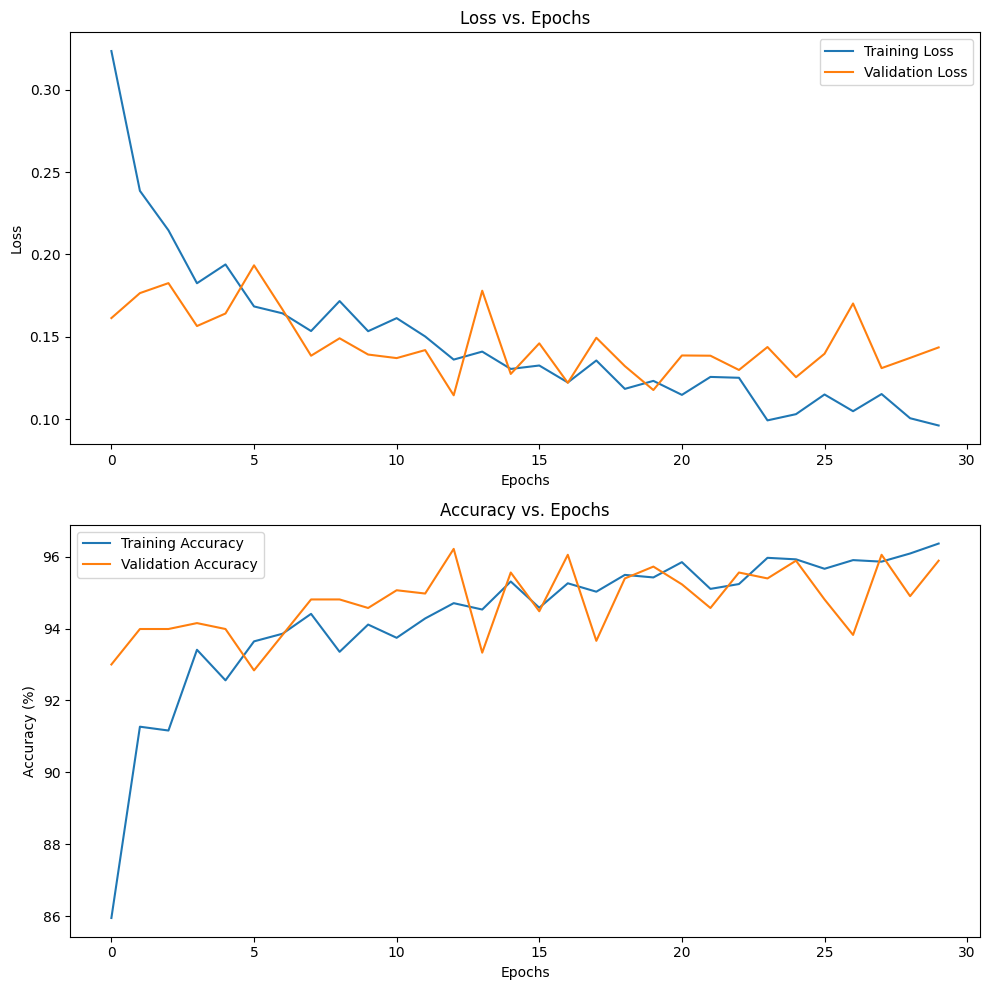

Model saved as 'improve_overfit_chest_xray_model.pth'


In [74]:
model = ImproveGeneralizationModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for binary classification

learning_rate = 0.0001 # same as lr, define it in case I forgot

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

# Save the model
torch.save(model.state_dict(), 'improve_overfit_chest_xray_model.pth')
print("Model saved as 'improve_overfit_chest_xray_model.pth'")

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_State the improvement you are justifying_

**(b)**

_Present your results, including plots etc, here_

**(c)**

_Discuss your results here_

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

**(a)**

_Present your results, including plots etc, here_

**(b)**

_Discuss your results here_